# Depuración, Inspección y Modularización de Modelos

Hasta ahora, te has centrado en construir y entrenar modelos. 
Pero en el mundo real, el primer intento de un modelo rara vez funciona a la perfección. 
A menudo te encontrarás con mensajes de error crípticos sobre dimensiones de tensores que no coinciden o, peor aún, tu modelo se ejecutará sin errores pero no producirá resultados significativos. 

Aquí es donde la **depuración (debugging), inspección y modularización** se convierten en habilidades esenciales. 
En este laboratorio, asumirás el papel de un investigador de modelos. 
Comenzarás con una Red Neuronal Convolucional (CNN) defectuosa y utilizarás técnicas de depuración sistemáticas para encontrar y corregir el error. Luego, aprenderás a refactorizar tu código para mayor claridad y reutilización, y finalmente, diseccionarás un modelo complejo pre-entrenado para comprender su funcionamiento interno.



En este laboratorio, tú vas a:

* **Depurar** una CNN defectuosa insertando sentencias de impresión (print) en el paso `forward` para identificar y corregir un error crítico de desajuste en la forma de los tensores.
* **Refactorizar** el modelo corregido utilizando `nn.Sequential` para crear una arquitectura más limpia, modular y menos propensa a errores.
* **Inspeccionar** las estadísticas de activación de tu modelo para realizar un control de coherencia (sanity check) ante problemas como la explosión o el desvanecimiento de gradientes.
* **Explorar** la arquitectura de un modelo preexistente y complejo (`SqueezeNet`) para contar sus capas y analizar su distribución de parámetros.

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import SqueezeNet

In [2]:
import helper_utils

## Carga de Datos

Para depurar e inspeccionar un modelo de manera efectiva, primero necesitarás un conjunto de datos (dataset) con el cual trabajar.
El objetivo de este laboratorio es practicar un flujo de trabajo de depuración e inspección de principio a fin, por lo que utilizarás un dataset sencillo que te permita concentrarte en la arquitectura del modelo en lugar de en un preprocesamiento de datos complejo.
Para este propósito, utilizarás el dataset Fashion MNIST, que consiste en imágenes en escala de grises de prendas de vestir y sirve como un punto de referencia (benchmark) directo para tareas de clasificación de imágenes.
Comenzarás cargando el dataset utilizando la librería torchvision de PyTorch y luego crearás un DataLoader para manejar eficientemente los datos en lotes (batches) durante el entrenamiento y la evaluación.

In [5]:
dataset = helper_utils.get_dataset()

transform = transforms.ToTensor()
dataset.transform = transform

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.23MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 151kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.80MB/s]


In [6]:
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [7]:
img_batch, label_batch = next(iter(dataloader))
print("Batch shape:", img_batch.shape)  # Should be [batch_size, 1, 28, 28]

Batch shape: torch.Size([64, 1, 28, 28])


## Depuración a través del paso hacia adelante (forward pass)

Al empezar a trabajar con un modelo nuevo, es común encontrarse con errores.
Estos errores pueden deberse a diversas razones, como formas de tensores incorrectas, operaciones incompatibles o valores inesperados.
A veces, el modelo puede ejecutarse sin errores pero producir salidas incorrectas.

En esta sección, explorarás cómo depurar un modelo de PyTorch examinando su paso hacia adelante (forward pass).

### Una primera exploración del modelo

Ha llegado el momento de explorar el modelo.
Este modelo es una red sencilla que cuenta con:
* Un bloque convolucional: que consiste en una capa convolucional, una función de activación ReLU y una capa de max pooling.
* Un bloque totalmente conectado (fully connected): que consiste en una capa lineal, una función de activación ReLU y una capa lineal final que genera las puntuaciones de las clases.

Primero, instanciarás el modelo e intentarás ejecutar un paso hacia adelante (forward pass) con un lote (batch) del dataloader.
Para obtener una salida más limpia en caso de errores, utilizarás `try/except` para capturar cualquier excepción que pueda surgir durante el proceso.

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Bloque Convolucional
        self.conv = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Bloque Fully Connected
        # Para Fashion MNIST: las imágenes de entrada son 28x28,
        # después de conv+pool: 32x14x14
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.relu_fc = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 clases para Fashion MNIST

    def forward(self, x):
        x = self.pool(self.relu(self.conv(x)))
        x = self.relu_fc(self.fc1(x))
        x = self.fc2(x)
        return x

In [15]:
simple_cnn = SimpleCNN()

try:
    output = simple_cnn(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass: {e}\033[0m")

Error during forward pass: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


De hecho, el modelo tal como se proporciona contiene algunos errores que requieren depuración.
El mensaje que proporciona PyTorch cuando ocurre un error puede ser a veces críptico.
Describe que dos matrices (`mat1` y `mat2`) no se pueden multiplicar y proporciona sus formas (shapes).
Esto indica que hay un desajuste en las dimensiones de los tensores que se están multiplicando, lo cual es un problema común en las implementaciones de redes neuronales.

Sin embargo, el mensaje de error no especifica **por qué y en qué parte** del modelo ocurre el error.
Ahí es donde entra en juego el método `forward` del modelo.
La naturaleza de grafo dinámico de PyTorch te permite insertar sentencias de impresión (print) o utilizar herramientas de depuración para inspeccionar los valores y las formas de los tensores en varios puntos del método `forward`.

Definirás una nueva clase que hereda del modelo original y sobrescribirás el método `forward` para incluir sentencias de impresión que muestren la forma del tensor después de cada capa.
Un primer intento podría ser separar explícitamente las capas en el método `forward` y, para cada capa:
* Imprimir la forma del tensor antes de la capa (forma de entrada).
* Imprimir la forma de algunos *parámetros de la capa* (por ejemplo, pesos y sesgos).
* Imprimir la forma del tensor de *activación* después de la capa (forma de salida), que será la entrada para la siguiente capa.

Ahora puedes ejecutar el paso hacia adelante nuevamente y observar las formas impresas para identificar dónde ocurre el desajuste.

In [ ]:
class SimpleCNNDebug(SimpleCNN):
    def __init__(self):
        super().__init__()
        # La llamada super().__init__() anterior inicializa correctamente todas las capas de SimpleCNN
        # No es necesario redefinir las capas aquí

    def forward(self, x):
        print("Forma de la entrada (Input shape):", x.shape)
        print(
            " (Componentes de capa) Parámetros de la capa Conv (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activación) Después de la convolución y ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activación) Después del pooling:", x_pool.shape)

        print(
            "(Componentes de capa) Parámetros de la capa Linear fc1 (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        # Aquí es donde el código arrojará el error al recibir el tensor sin aplanar
        x_fc1 = self.relu_fc(self.fc1(x_pool))

        print("===")

        print("(Activación) Después de fc1 y ReLU:", x_fc1.shape)

        print(
            "(Componentes de capa) Parámetros de la capa Linear fc2 (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activación) Después de fc2 (salida):", x.shape)
        return x

In [21]:
simple_cnn_debug = SimpleCNNDebug()

try:
    output_debug = simple_cnn_debug(img_batch)  
except Exception as e:
    print(f"\033[91mError during forward pass in debug model: {e}\033[0m")

Input shape: torch.Size([64, 1, 28, 28])
 (Layer components) Conv layer parameters (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activation) After convolution and ReLU: torch.Size([64, 32, 28, 28])
(Activation) After pooling: torch.Size([64, 32, 14, 14])
(Layer components) Linear layer fc1 parameters (weights, biases): torch.Size([128, 6272]) torch.Size([128])
Error during forward pass in debug model: mat1 and mat2 shapes cannot be multiplied (28672x14 and 6272x128)


Esta es una salida mucho más clara. Ya puedes ver que todas las capas del bloque convolucional están funcionando bien y las formas son las esperadas (`batch_size=64` y `out_channels=32`).

**El error ocurre en el bloque totalmente conectado (fully connected)**, específicamente en la primera capa lineal: `x_pool` tiene una forma de `[64, 32, 14, 14]`, pero la capa lineal espera una entrada de forma `[64, 6272]` (su matriz de pesos tiene una forma de `[128, 6272]`).

Dado que la capa lineal `fc1` espera una entrada en 2D de forma `[batch_size, input_features]`, el tensor `x_pool` se está aplanando incorrectamente a un tensor 2D con forma `[64*32*14, 14]` antes de ser pasado a `fc1`. Esta no es la forma deseada y es lo que provoca el error de desajuste de dimensiones.

Una vez que hayas identificado el problema, puedes solucionarlo añadiendo una operación de aplanado (flatten) antes de la primera capa lineal en el método `forward`.

In [24]:
class SimpleCNNFixed(SimpleCNN):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        print("Forma de la entrada (Input shape):", x.shape)
        print(
            " (Componentes de neurona) Parámetros de la capa Conv (weights, biases):",
            self.conv.weight.shape,
            self.conv.bias.shape,
        )
        x_conv = self.relu(self.conv(x))

        print("===")

        print("(Activación) Después de la convolución y ReLU:", x_conv.shape)
        x_pool = self.pool(x_conv)
        print("(Activación) Después del pooling:", x_pool.shape)

        x_flattened = torch.flatten(
            x_pool, start_dim=1
        )  # Aplana todas las dimensiones excepto el batch
        print("(Activación) Después del flattening:", x_flattened.shape)

        print(
            "(Componentes de neurona) Parámetros de la capa Linear fc1 (weights, biases):",
            self.fc1.weight.shape,
            self.fc1.bias.shape,
        )

        x_fc1 = self.relu_fc(self.fc1(x_flattened))

        print("===")

        print("(Activación) Después de fc1 y ReLU:", x_fc1.shape)

        print(
            "(Componentes de neurona) Parámetros de la capa Linear fc2 (weights, biases):",
            self.fc2.weight.shape,
            self.fc2.bias.shape,
        )
        x = self.fc2(x_fc1)

        print("===")

        print("(Activación) Después de fc2 (salida final):", x.shape)
        return x

In [23]:
# Fixed version
simple_cnn_fixed = SimpleCNNFixed()

output = simple_cnn_fixed(img_batch)

Forma de la entrada (Input shape): torch.Size([64, 1, 28, 28])
 (Componentes de neurona) Parámetros de la capa Conv (weights, biases): torch.Size([32, 1, 3, 3]) torch.Size([32])
===
(Activación) Después de la convolución y ReLU: torch.Size([64, 32, 28, 28])
(Activación) Después del pooling: torch.Size([64, 32, 14, 14])
(Activación) Después del flattening: torch.Size([64, 6272])
(Componentes de neurona) Parámetros de la capa Linear fc1 (weights, biases): torch.Size([128, 6272]) torch.Size([128])
===
(Activación) Después de fc1 y ReLU: torch.Size([64, 128])
(Componentes de neurona) Parámetros de la capa Linear fc2 (weights, biases): torch.Size([10, 128]) torch.Size([10])
===
(Activación) Después de fc2 (salida final): torch.Size([64, 10])


¡El problema ya está solucionado y el modelo se ejecuta sin errores! Puedes ver que las formas de los tensores son las esperadas después de cada capa, y la salida final tiene la forma correcta de `[64, 10]`, que corresponde al tamaño del lote (batch size) y al número de clases.

Una vez que el modelo esté funcionando sin errores, puedes saltar a la siguiente sección para refactorizar el modelo utilizando `nn.Sequential`, logrando así una implementación más limpia y modular.

## `nn.Sequential` para la Modularización

El modelo ya funciona correctamente, pero el método `forward` es bastante extenso y repetitivo.
Para que el código sea más limpio y modular, puedes utilizar `nn.Sequential` para definir los bloques convolucionales y totalmente conectados.

De esta manera, obtienes varias ventajas:
* **Modularidad**: Cada bloque se define como un módulo independiente, lo que facilita su comprensión y modificación.
* **Reusabilidad**: Puedes reutilizar fácilmente los bloques en otros modelos o experimentos.
* **Código más limpio**: El método `forward` se vuelve mucho más sencillo, ya que solo necesita llamar a los bloques de forma secuencial.
* **Menos propenso a errores**: Al definir los bloques en un solo lugar, reduces las posibilidades de cometer errores al implementar el método `forward`.

In [25]:
class SimpleCNN2Seq(nn.Module):
    def __init__(self):
        super().__init__()
        # Bloque Convolucional
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # Bloque Fully Connected
        # Para Fashion MNIST: las imágenes de entrada son 28x28,
        # después de conv+pool: 32x14x14
        flattened_size = 32 * 14 * 14
        self.fc_block = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.ReLU(),
            nn.Linear(128, 10),  # 10 clases para Fashion MNIST
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = torch.flatten(x, start_dim=1)  # Aplanar todas las dimensiones excepto el batch
        x = self.fc_block(x)
        return x

In [26]:
simple_cnn_seq = SimpleCNN2Seq()
output = simple_cnn_seq(img_batch)

print("Output shape from sequential model:", output.shape)

Output shape from sequential model: torch.Size([64, 10])


### Inspección Estadística de la Inicialización

Una comprobación común al inspeccionar un modelo es observar las estadísticas de algunas activaciones para asegurarse de que se encuentran dentro de un rango razonable.

In [27]:
class SimpleCNN2SeqDebug(SimpleCNN2Seq):
    def __init__(self):
        super().__init__()
        # La llamada super().__init__() anterior inicializa correctamente todas las capas de SimpleCNN2Seq
        # No es necesario redefinir las capas aquí

    def get_statistics(self, activation):
        mean = activation.mean().item()
        std = activation.std().item()
        min_val = activation.min().item()
        max_val = activation.max().item()

        print(f" Media: {mean}")
        print(f" Desv. Est.: {std}")
        print(f" Mín: {min_val}")
        print(f" Máx: {max_val}")
        return mean, std, min_val, max_val

    def forward(self, x):
        features = self.conv_block(x)
        x = torch.flatten(features, start_dim=1)  # Aplanar todas las dimensiones excepto el batch

        print("Después de conv_block, las estadísticas de activación son:")
        self.get_statistics(features)

        x = self.fc_block(x)
        print("Después de fc_block, las estadísticas de activación son:")
        self.get_statistics(x)
        return x

In [28]:
simple_cnn_seq_debug = SimpleCNN2SeqDebug()

for idx, (img_batch, _) in enumerate(dataloader):
    if idx < 5:
        print(f"=== Batch {idx} ===")
        output_debug = simple_cnn_seq_debug(img_batch)

=== Batch 0 ===
Después de conv_block, las estadísticas de activación son:
 Media: 0.1867416799068451
 Desv. Est.: 0.25723981857299805
 Mín: 0.0
 Máx: 1.6064507961273193
Después de fc_block, las estadísticas de activación son:
 Media: 0.04099445417523384
 Desv. Est.: 0.08808427304029465
 Mín: -0.17866753041744232
 Máx: 0.2789860665798187
=== Batch 1 ===
Después de conv_block, las estadísticas de activación son:
 Media: 0.1915968507528305
 Desv. Est.: 0.265992134809494
 Mín: 0.0
 Máx: 1.5845611095428467
Después de fc_block, las estadísticas de activación son:
 Media: 0.04180184379220009
 Desv. Est.: 0.08947749435901642
 Mín: -0.1646321415901184
 Máx: 0.2752054035663605
=== Batch 2 ===
Después de conv_block, las estadísticas de activación son:
 Media: 0.1915162354707718
 Desv. Est.: 0.2662627696990967
 Mín: 0.0
 Máx: 1.5778504610061646
Después de fc_block, las estadísticas de activación son:
 Media: 0.041578397154808044
 Desv. Est.: 0.09228544682264328
 Mín: -0.17502059042453766
 Máx: 0.

Esta es una comprobación de coherencia (sanity check) para asegurar que el modelo está inicializado correctamente y que las activaciones no están explotando o desvaneciéndose.
*Estos problemas pueden derivar en un rendimiento de entrenamiento deficiente o en problemas de convergencia.*

## Inspección del Modelo

Con el modelo anterior funcionando correctamente, ahora inspeccionarás un modelo complejo preexistente de `torchvision.models`, como `SqueezeNet`.

En esta sección, harás uso de las utilidades de inspección proporcionadas por PyTorch para explorar la arquitectura, las capas y los parámetros del modelo.
Estas técnicas de inspección son fundamentales para una depuración efectiva y para realizar modificaciones informadas en tus diseños de redes neuronales.

### Descripción General de la Arquitectura

In [29]:
# Load SqueezeNet model
complex_model = SqueezeNet()

print(complex_model)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

Para modelos complejos, imprimir la arquitectura completa del modelo puede resultar abrumador.
En su lugar, puedes hacer uso de `named_children()` y `children()` para iterar a través de los bloques de nivel superior del modelo.

In [30]:
# Iterar a través de los bloques principales
for name, block in complex_model.named_children():
    print(f"El bloque {name} tiene un total de {len(list(block.children()))} capas:")
    
    # Listar todas las capas hijas (children layers) en el bloque
    for idx, layer in enumerate(block.children()):
        # Verificar si la capa es terminal (sin hijas) o no
        if len(list(layer.children())) == 0:
            print(f"\t {idx} - Capa {layer}")
        # Si la capa tiene hijas, es un sub-bloque; entonces imprimir solo el número de hijas y su nombre
        else:
            layer_name = layer._get_name()  # Nombre más amigable para el usuario
            print(f"\t {idx} - Sub-bloque {layer_name} con {len(list(layer.children()))} capas")      

El bloque features tiene un total de 13 capas:
	 0 - Capa Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
	 1 - Capa ReLU(inplace=True)
	 2 - Capa MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 3 - Sub-bloque Fire con 6 capas
	 4 - Sub-bloque Fire con 6 capas
	 5 - Sub-bloque Fire con 6 capas
	 6 - Capa MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 7 - Sub-bloque Fire con 6 capas
	 8 - Sub-bloque Fire con 6 capas
	 9 - Sub-bloque Fire con 6 capas
	 10 - Sub-bloque Fire con 6 capas
	 11 - Capa MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
	 12 - Sub-bloque Fire con 6 capas
El bloque classifier tiene un total de 4 capas:
	 0 - Capa Dropout(p=0.5, inplace=False)
	 1 - Capa Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
	 2 - Capa ReLU(inplace=True)
	 3 - Capa AdaptiveAvgPool2d(output_size=(1, 1))


Esto proporciona una visión general más limpia de la estructura del modelo, permitiéndote enfocarte en los componentes principales sin perderte en los detalles de cada capa individual.
Ahora harás un "zoom" en uno de los módulos `Fire` para ver su estructura interna.

Para ello, puedes usar `modules()` para iterar a través de todas las capas y sub-módulos del modelo.

In [31]:
first_fire_module = complex_model.features[3]

for idx, module in enumerate(first_fire_module.modules()):
    # Avoid printing the top-level module itself
    if idx > 0 :
        print(module)

Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
ReLU(inplace=True)
Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)


Ahora la arquitectura del modelo se imprime de forma ordenada, mostrando los componentes principales y sus configuraciones.
Ahora puedes realizar algunas inspecciones específicas, como contar el número de tipos de capas específicos o calcular el número total de parámetros en el modelo.

### Inspección Detallada

Ahora contarás cuántas capas `Conv2d` hay en el modelo.

In [32]:
type_layer = nn.Conv2d

selected_layers = [layer for layer in complex_model.modules() if isinstance(layer, type_layer)]

print(f"Number of {type_layer.__name__} layers: {len(selected_layers)}")

Number of Conv2d layers: 26


Ahora contarás el número total de parámetros en el modelo.
Esto te da una idea de la complejidad y la capacidad del modelo.

In [33]:
# total number of parameters in the model
total_params = sum(p.numel() for p in complex_model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 1248424


Ahora, puedes ir un paso más allá inspeccionando los parámetros de cada capa terminal (capas sin hijos) del modelo.
Para cada capa terminal, imprimirás su nombre y el número total de parámetros que contiene.
Esto ayuda a identificar qué capas contribuyen más al conteo de parámetros del modelo y puede ser útil para la optimización del modelo, el pruning, o para entender dónde reside la capacidad del mismo.

Layer features.0 has 14208 parameters
Layer features.1 has 0 parameters
Layer features.2 has 0 parameters
Layer features.3.squeeze has 1552 parameters
Layer features.3.squeeze_activation has 0 parameters
Layer features.3.expand1x1 has 1088 parameters
Layer features.3.expand1x1_activation has 0 parameters
Layer features.3.expand3x3 has 9280 parameters
Layer features.3.expand3x3_activation has 0 parameters
Layer features.4.squeeze has 2064 parameters
Layer features.4.squeeze_activation has 0 parameters
Layer features.4.expand1x1 has 1088 parameters
Layer features.4.expand1x1_activation has 0 parameters
Layer features.4.expand3x3 has 9280 parameters
Layer features.4.expand3x3_activation has 0 parameters
Layer features.5.squeeze has 4128 parameters
Layer features.5.squeeze_activation has 0 parameters
Layer features.5.expand1x1 has 4224 parameters
Layer features.5.expand1x1_activation has 0 parameters
Layer features.5.expand3x3 has 36992 parameters
Layer features.5.expand3x3_activation has 

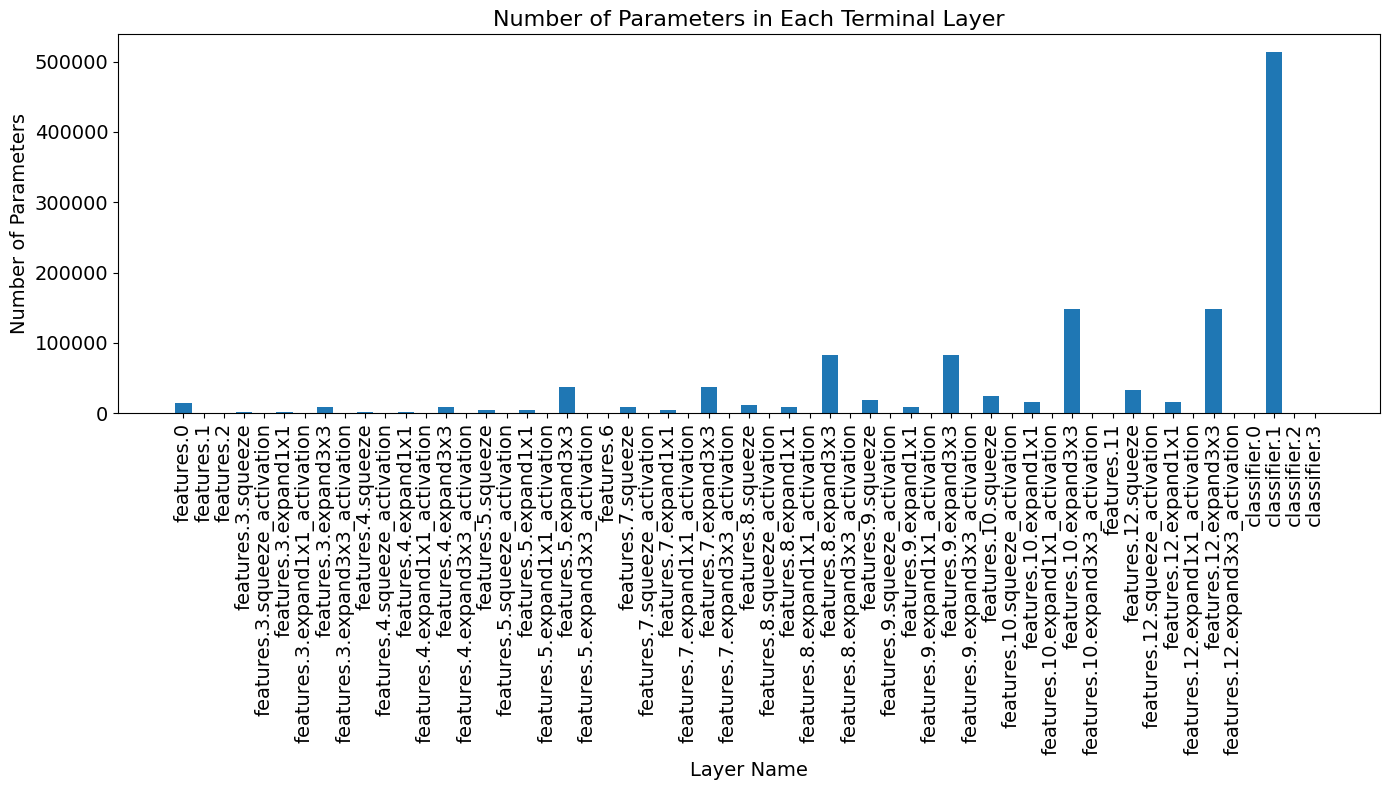

In [34]:
counting_params = {}

# For each terminal layer print its number of parameters
for layer in complex_model.named_modules():
    n_children = len(list(layer[1].children()))
    if n_children == 0:  # Terminal layer
        layer_name = layer[0]
        n_parameters = sum(p.numel() for p in layer[1].parameters())
        counting_params[layer_name] = n_parameters
        print(f"Layer {layer_name} has {n_parameters} parameters")

# Plotting the distribution of parameters per layer
helper_utils.plot_counting(counting_params)

# Conclusión

Has depurado, refactorizado e inspeccionado con éxito modelos de PyTorch. 
En este laboratorio, viste de primera mano que el `forward` pass de un modelo no es una caja negra y que, al añadir sentencias de impresión estratégicamente, puedes diagnosticar y resolver errores comunes pero frustrantes como los desajustes de forma (shape mismatches).

Has ido más allá de simplemente escribir código de modelos y ahora puedes hacerlos más robustos y legibles agrupando capas en bloques lógicos con **`nn.Sequential`**. 
Esta práctica de modularización hace que tus arquitecturas sean más fáciles de entender, reutilizar y adaptar. 
También aprendiste cómo realizar comprobaciones de coherencia (sanity checks) esenciales inspeccionando las estadísticas de activación y cómo explorar sistemáticamente cualquier modelo de PyTorch, por muy complejo que sea, utilizando utilidades de inspección como `.modules()` y `.named_children()`.

Con estas habilidades fundamentales de depuración e inspección, estás bien preparado para desafíos más avanzados.